# Header
### Importing modules and reading data

In [41]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as sm
import statsmodels.api as old_sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Define Heaviside function as H(x)=0 for x<0, H(x)=1/2 for x=0, H(x)=1 for x>0
def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

# Import data
try:
    all_seasons = pd.read_csv("Long_History.csv", encoding='utf-8', index_col=0)
    
    # Write DF to give teams numerical ID, and as lookup for team names and their ID
    teamlist = all_seasons.loc[:, "TeamH"].unique()
    data = np.array([range(len(teamlist)), teamlist]).T
    team_df = pd.DataFrame(data=data, columns=['TID', 'TName'])

except:
    print "Data import failed"

### Formatting data and writing standings

In [42]:
cleaned_df = pd.merge(team_df, all_seasons, how='inner', left_on='TName', right_on='TeamH')
cleaned_df = pd.merge(team_df, cleaned_df, how='inner', left_on='TName', right_on='TeamA', suffixes=('_A', '_H'))

columns_cl = ['Season', 'Gameday', 'TID_H', 'TID_A', 'FTHG', 'FTAG']
cleaned_df = cleaned_df.loc[:, columns_cl].sort_values(['Season', 'Gameday'])
cleaned_df.index = range(len(cleaned_df))

cleaned_df.loc[:, 'FTGD'] = cleaned_df.loc[:, 'FTHG'] - cleaned_df.loc[:, 'FTAG']

cleaned_df = cleaned_df.applymap(int)

In [43]:
def standings(df):
    def points(x):
        if x > 0:
            return 3
        elif x == 0:
            return 1
        else:
            return 0
    multi_index = pd.MultiIndex(levels=[[],[],[]],
                                labels=[[],[],[]],
                                names=[u'TID', u'Season', u'Gameday'])
    table_df = pd.DataFrame(data=None, columns=['Points', 'GD'], index=multi_index)
    
    for tid in range(len(team_df)):
        query = 'TID_H == ' + str(tid)
        temp_H = df.query(query).loc[:, ['TID_H', 'Season', 'Gameday', 'FTGD', 'FTHG']]
        temp_H.columns = ['TID_H', 'Season', 'Gameday', 'FTGD', 'FTG']
        temp_H.loc[:, 'GD'] = temp_H.loc[:, 'FTGD']
        temp_H = temp_H.drop('FTGD', axis=1)
        temp_H = temp_H.set_index(['TID_H', 'Season', 'Gameday'])

        query = 'TID_A == ' + str(tid)
        temp_A = df.query(query).loc[:, ['TID_A', 'Season', 'Gameday', 'FTGD', 'FTAG']]
        temp_A.columns = ['TID_A', 'Season', 'Gameday', 'FTGD', 'FTG']
        temp_A.loc[:, 'GD'] = -1 * temp_A.loc[:, 'FTGD']
        temp_A = temp_A.drop('FTGD', axis=1)
        temp_A = temp_A.set_index(['TID_A', 'Season', 'Gameday'])

        temp_df = pd.concat([temp_H, temp_A]).sort_index()
        temp_df.index = temp_df.index.rename(['TID', 'Season', 'Gameday'])
        temp_df.loc[:, 'Points'] = temp_df.loc[:, 'GD'].apply(points).rename('Points').to_frame()

        table_df = table_df.append(temp_df.groupby(level=['TID', 'Season'], group_keys=False).cumsum())
    
    return table_df

table_df = standings(cleaned_df)
table_df.loc[:, "Points_Plus"] = table_df.loc[:, "Points"] + 0.25/table_df.index.get_level_values(2) * table_df.loc[:, "GD"]
table_df.loc[:, "Rank"] = table_df.loc[:, "Points_Plus"].groupby(level=["Season", "Gameday"]).rank(ascending=False)

# Season end standings
# Update most recent season such that we calculate it as if 34 Games have been played.
# Normalize points to fraction of total points in season.
table_extrap_df = \
    table_df.loc[:, ["Points", "GD"]].groupby(level=['Season', 'TID']).last()/table_df.loc[:, ["Points", "GD"]].groupby(level=['Season', 'TID']).count()
table_extrap_df = table_extrap_df/[3.,1.]
    
table_extrap_by_team_df = pd.concat([
        table_extrap_df.groupby(level=['TID']).mean(), 
        table_extrap_df.groupby(level=['TID']).count().loc[:, "GD"].to_frame("Seasons")], axis = 1)

# Data Analysis
## Points at the end of the season vs goal differential

Often, the goal differential is a better indicator of playing strength than the amount of points.  
Why?  Unlike in other sports, scoring events in soccer are really rare.  At the same time, the difference between a 1-0, 2-0, or 3-0 is virtually non-existent for the final standings.  In other words, aside from adding some insurance to the lead, there is no incentive to win as high as possible.  You just have to win.  At the same time, however, a much stronger team will almost automatically score more goals per game.

Question: Is one season long enough to equilibrate?  In other words, will the goal differential explain most of the variance in points?

                              Regression Summary                              
Dep. Variable:                 Points   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     7237.
Date:                Mon, 27 Feb 2017   Prob (F-statistic):               0.00
Time:                        20:46:04   Log-Likelihood:                 1625.1
No. Observations:                 918   AIC:                            -3246.
Df Residuals:                     916   BIC:                            -3237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4575      0.001    336.032      0.0

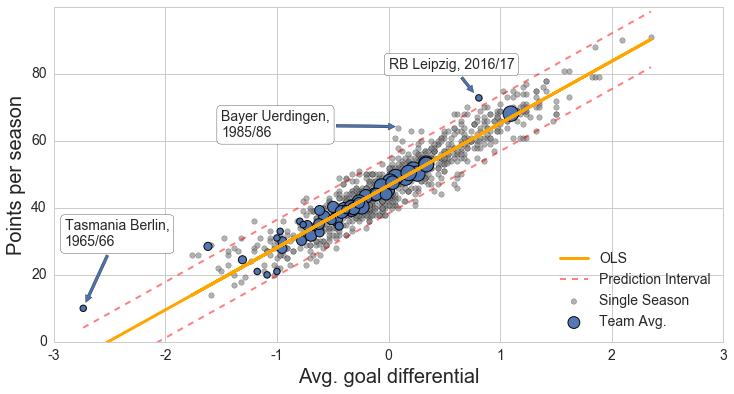

In [79]:
fig, ax = plt.subplots()

# Linear regression of points per GD; 
result = sm.ols(formula="Points ~ GD", data=table_extrap_df.loc[:, ["Points", "GD"]]).fit()
intercept_gd, slope_gd = result.params

# Formally defined
def points_per_GD(x):
    try: 
        len(x)
    except:
        x = [x]
    return result.predict(pd.DataFrame(data=x, columns=["GD"]))[0]

# Fast application
# def points_per_GD(x):
#     return intercept_gd + x * slope_gd

table_extrap_df.plot(ax=ax, kind='scatter', x='GD', y='Points', s=30, c='gray',
                     alpha=0.6, figsize=(12,6), grid=True, sharex=False, xlim=(-3,3), ylim=(0, 1./1.02), label='Single Season')

table_extrap_by_team_df.plot(ax=ax, kind='scatter', x='GD', y='Points', alpha=0.95, edgecolor='k', linewidth=1,
                             s=60*np.log(1+table_extrap_by_team_df.loc[:, "Seasons"]), label='Team Avg.')

plt.xlabel('Avg. goal differential', fontsize=20)
plt.ylabel('Points per season', fontsize=20)

# Plot 95% prediction interval
prstd, iv_l, iv_u = wls_prediction_std(result)
x = table_extrap_df.loc[:, "GD"].values
y = points_per_GD(x)
plt.plot(x, result.fittedvalues, c='orange', label='OLS', linewidth=3)
x_ix_min = np.where(x==min(x))[0][0]
x_ix_max = np.where(x==max(x))[0][0]
plt.plot([x[x_ix_min],x[x_ix_max]], [iv_u[x_ix_min], iv_u[x_ix_max]], 'r--', alpha=0.5, linewidth=2, label='Prediction Interval')
plt.plot([x[x_ix_min],x[x_ix_max]], [iv_l[x_ix_min], iv_l[x_ix_max]], 'r--', alpha=0.5, linewidth=2)

# Annotate outliers in plot
ax.annotate("RB Leipzig, 2016/17", bbox=dict(boxstyle="round", fc="w"), fontsize=14,
            xy=(0.775, 0.725), xycoords='data',
            xytext=(0.0, 0.8), textcoords='data',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3"))

ax.annotate("Tasmania Berlin,\n1965/66", bbox=dict(boxstyle="round", fc="w"), fontsize=14,
            xy=(-2.72, 0.11), xycoords='data',
            xytext=(-2.9, 0.28), textcoords='data',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3"))

ax.annotate("Bayer Uerdingen,\n1985/86", bbox=dict(boxstyle="round", fc="w"), fontsize=14,
            xy=(0.08, 0.63), xycoords='data',
            xytext=(-1.5, 0.6), textcoords='data',
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3"))

# Formatting
ax.set_yticks(np.arange(0, 100./102,20./102))
ax.set_yticklabels(np.arange(0, 100,20), fontsize=14)
ax.set_xticklabels(range(-3,4,1), fontsize=14)
plt.legend(loc=4, fontsize=14)

print result.summary(title='Regression Summary', )

It does! $R^2 = 0.888$, so about 90% of the variance in the points can be explained by the goal differential alone. 
The best teams at the end of the season are those who more often outscore their opponents clearly.

## Points and goal differential in the middle of the season vs season outcome

Now that we know that the goal differential can explain a lot of the variance in the points, let's look at the standings in the middle of the season, e.g. after 10 games. How successfully can we use points and goal differential after 10 games to describe the rest of the season?

In [120]:
def comparison(gd, last_year=None, first_year=None):
    if last_year == None:
        last_year = 2016
    if first_year == None:
        first_year = 1965

    comparison_df = \
    pd.merge(
        table_df.query("Season>="+str(first_year-1)+" & Season<="+str(last_year)+" & Gameday=="+str(gd)).reset_index("Gameday", drop=True),
        table_df.query("Season>="+str(first_year-1)+" & Season<="+str(last_year)+" & Gameday==34").reset_index("Gameday", drop=True),
        left_index=True, right_index=True, how='left', suffixes=("_"+str(gd), "_34"))
    
    comparison_df.loc[:, "Points_Gained"] = comparison_df.loc[:, "Points_34"] - comparison_df.loc[:, "Points_"+str(gd)]
    comparison_df.loc[:, "Points_Gained_Plus"] = comparison_df.loc[:, "Points_Plus_34"] - comparison_df.loc[:, "Points_Plus_"+str(gd)]
    comparison_df.loc[:, "Points_Plus_"+str(gd)+"_Overshoot"] = - 3*gd*(comparison_df.loc[:, "GD_"+str(gd)]/gd).apply(points_per_GD) + comparison_df.loc[:, "Points_Plus_"+str(gd)]

    
    # Find the rank of the team in the previous season. If new team to league, set 18.
    # Take out the years 1965 and 1992 because they don't have a valid year before it.
    # 1965 first year of BL, 1991 empty DF because season was played with 20 teams instead of 18.
    comparison_df.loc[:, "Rank_m1"] = comparison_df.groupby(level='TID').shift(1).loc[:, "Rank_34"].fillna(18)
    comparison_df.loc[:, "Points_Plus_m1"] = comparison_df.groupby(level='TID').shift(1).loc[:, "Points_Plus_34"]
    comparison_df.loc[:, "GD_m1"] = comparison_df.groupby(level='TID').shift(1).loc[:, "GD_34"]
    comparison_df = comparison_df.query("Season!=1965 & Season!=1992").applymap(np.float)

    # Normalize to: GD per game, Points out of possible points, Overshoot absolute
    comparison_df = comparison_df / [gd, gd, 3*gd, 3*gd, 1, 34, 34, 102, 102, 1, 3*(34-gd), 3*(34-gd), 1, 1, 102, 34]
    return comparison_df.query("Season>="+str(first_year))

In [121]:
gd = 12
comparison_df = comparison(gd, 2015)

                            OLS Regression Results                            
Dep. Variable:         Points_Plus_34   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     734.4
Date:                Mon, 27 Feb 2017   Prob (F-statistic):          7.84e-187
Time:                        21:58:04   Log-Likelihood:                 1012.0
No. Observations:                 864   AIC:                            -2018.
Df Residuals:                     861   BIC:                            -2004.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          0.2798      0.018     15.

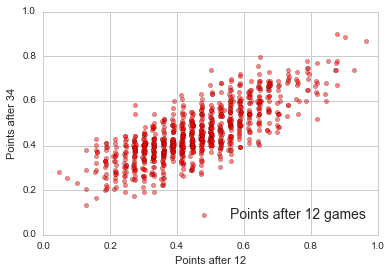

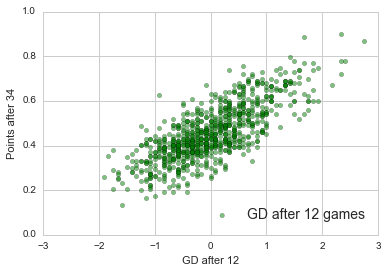

In [122]:
fig, ax = plt.subplots()
comparison_df.loc[:, ["Points_Plus_34", 
                      "Points_Plus_"+str(gd)]].plot(kind='scatter', x="Points_Plus_"+str(gd), y="Points_Plus_34",
                                                    c='r', alpha=0.5, label="Points after " + str(gd) + " games", 
                                                    ylim=(0,1), xlim=(0,1), ax=ax)
ax.set_xlabel("Points after " + str(gd))
ax.set_ylabel("Points after 34")
plt.legend(loc=4, fontsize=14)

fig, ax = plt.subplots()
comparison_df.loc[:, ["Points_Plus_34",
                      "GD_"+str(gd)]].plot(kind='scatter', x="GD_"+str(gd), y="Points_Plus_34", 
                                           c='g', alpha=0.5, label="GD after " + str(gd) + " games",
                                           ylim=(0,1), xlim=(-3,3), ax=ax)
ax.set_xlabel("GD after " + str(gd))
ax.set_ylabel("Points after 34")

plt.legend(loc=4, fontsize=14)
print sm.ols(formula='Points_Plus_34 ~ Points_Plus_'+str(gd)+'+GD_'+str(gd), data=comparison_df).fit().summary()

## How much better will a team do for the rest of the season?
Our previous analysis is biased: Points after 10 games are part of the points after 34 games. Let's instead look at the points gained throughout the rest of the season. We extend the scope by including results from last season and the overshoot. 
Using the connection between goal differential and points we've found in the beginning, 
$\langle P(x)\rangle \approx 0.182\,\mathrm{x} + 0.457$,
where $P(x)$ is the expected points and $x$ is the goal differential, we calculate how many points the team has scored more than expected given its goal differential, which we call the overshoot.

In [123]:
comparison_df.head()

FTG_12     GD_12  Points_12  Points_Plus_12  Rank_12    FTG_34  \
TID Season                                                                     
1   1966    1.250000 -0.583333   0.361111        0.357060     16.0  1.411765   
    1967    1.750000  0.250000   0.444444        0.446181     10.0  1.911765   
    1968    1.583333  0.333333   0.444444        0.446759      8.5  1.764706   
    1969    2.083333  0.000000   0.500000        0.500000      8.0  1.735294   
    1970    1.750000  0.333333   0.527778        0.530093      6.0  1.441176   

               GD_34  Points_34  Points_Plus_34  Rank_34  Points_Gained  \
TID Season                                                                
1   1966   -0.176471   0.421569        0.421136     12.0       0.454545   
    1967    0.323529   0.480392        0.481185      8.5       0.500000   
    1968    0.176471   0.490196        0.490629      4.0       0.515152   
    1969   -0.088235   0.480392        0.480176      6.0       0.469697   
    1970    0.000000   0.401961        0.401961     12.0       0.333333   

            Points_Gained_Plus  Points_Plus_12_Overshoot  Rank_m1  \
TID Season                                                          
1   1966              0.456087                  0.208305     11.0   
    1967              0.500279                 -2.045478     12.0   
    1968              0.514557                 -2.570857      8.5   
    1969              0.469363                  1.530657      4.0   
    1970              0.332071                  0.429143      6.0   

            Points_Plus_m1     GD_m1  
TID Season                            
1   1966          0.440744 -0.176471  
    1967          0.421136 -0.176471  
    1968          0.481185  0.323529  
    1969          0.490629  0.176471  
    1970          0.480176 -0.088235

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Points_Gained_Plus   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     153.2
Date:                Mon, 27 Feb 2017   Prob (F-statistic):           5.93e-79
Time:                        21:58:12   Log-Likelihood:                 675.51
No. Observations:                 830   AIC:                            -1343.
Df Residuals:                     826   BIC:                            -1324.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                    0.1237      0.016      7.539      0.000         0.092     0.156
Points_Plus_m1               0.4139      0.036     11.412      0.000         0.343     0.485
Points_Plus_12               0.3159      0.032      9.914      0.000         0.253     0.378
Points_Plus_12_Overshoot    -0.0085      0.002     -4.515      0.000        -0.012    -0.005
==============================================================================
Omnibus:                        0.483   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.785   Jarque-Bera (JB):                0.425
Skew:                           0.054   Prob(JB):                        0.808
Kurtosis:                       3.024   Cond. No.                         26.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

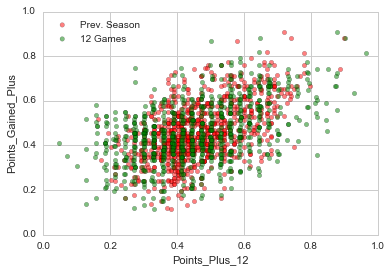

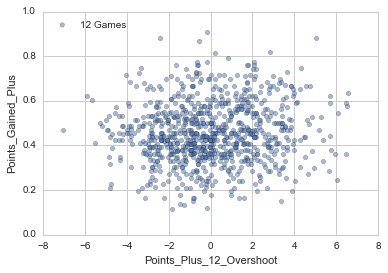

In [124]:
fig, ax = plt.subplots()

comparison_df.loc[:, ["Points_Gained_Plus", 
                      "Points_Plus_m1"]].plot(kind='scatter', x="Points_Plus_m1", y="Points_Gained_Plus",
                                              ax=ax, c='r', alpha=0.5, label="Prev. Season", ylim=(0,1), xlim=(0,1))
comparison_df.loc[:, ["Points_Gained_Plus", 
                      "Points_Plus_"+str(gd)]].plot(kind='scatter', x="Points_Plus_"+str(gd), y="Points_Gained_Plus",
                                                    ax=ax, c='g', alpha=0.5, label=str(gd)+ " Games")
plt.legend(loc=2)

comparison_df.loc[:, ["Points_Gained_Plus", 
                      "Points_Plus_"+str(gd)+"_Overshoot"]].plot(kind='scatter', x="Points_Plus_"+str(gd)+"_Overshoot", 
                                                                 y="Points_Gained_Plus", 
                                                                 alpha=0.5, label=str(gd)+ " Games", xlim=(-8,8))
plt.legend(loc=2)

sm.ols(formula='Points_Gained_Plus ~ Points_Plus_m1+Points_Plus_'+str(gd)+'+Points_Plus_'+str(gd)+'_Overshoot',
       data=comparison_df).fit().summary()

We explore the regression results, focussing on the points gained after a certain gameday.
<ul>
 <li>We know that the influence of the last season should wane over the running season. How much?</li>
 <li>After exactly 17 games, every team has played each other team once. Before and after the winter break the data is influenced by schedule. How much?</li>
 <li>Given these influences and interplays: How does $R^2$ depend on the gameday?</li>
</ul>

In [154]:
def eval_parameters():
    params = []
    for gd in range(1, 34, 1):
        comparison_df = comparison(gd, 2015)
        fit = sm.ols(formula='Points_Gained_Plus ~ Points_Plus_m1+Points_Plus_'+str(gd)+'+Points_Plus_'+str(gd)+'_Overshoot',
                     data=comparison_df).fit()
        params.append([gd, fit.rsquared] + fit.params.tolist())

    return pd.DataFrame(data=params, 
                        columns=["GD", "R^2", "Intercept", "Last_Season", "Curr_Season", "Overshoot"]).set_index("GD")

eval_parameters_df = eval_parameters()

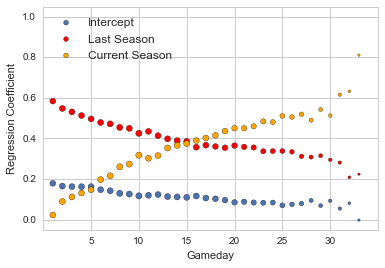

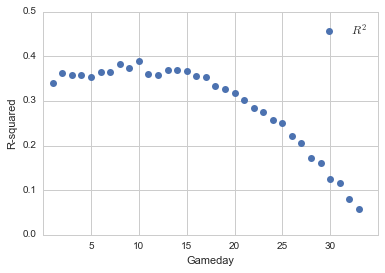

In [197]:
fig, ax = plt.subplots()
ax.set_xticks(range(5,35,5))
eval_parameters_df.reset_index().loc[:, ["GD", "Intercept"]].plot(kind='scatter', x='GD', y='Intercept', label='Intercept',
                                                                  s=100*eval_parameters_df.loc[:, "R^2"], 
                                                                  xlim=(0,35), ylim=(-0.05, 1.05), ax=ax)

eval_parameters_df.reset_index().loc[:, ["GD", "Last_Season"]].plot(kind='scatter', x='GD', y='Last_Season', label='Last Season',
                                                                  s=100*eval_parameters_df.loc[:, "R^2"], c='r',
                                                                  xlim=(0,35), ylim=(-0.05, 1.05), ax=ax)

eval_parameters_df.reset_index().loc[:, ["GD", "Curr_Season"]].plot(kind='scatter', x='GD', y='Curr_Season', label='Current Season',
                                                                  s=100*eval_parameters_df.loc[:, "R^2"], c='orange',
                                                                  xlim=(0,35), ylim=(-0.05, 1.05), ax=ax)
ax.set_xlabel("Gameday")
ax.set_ylabel("Regression Coefficient")
plt.legend(loc=2, fontsize=12)


fig, ax = plt.subplots()
ax.set_xticks(range(5,35,5))
eval_parameters_df.loc[:, "R^2"].plot(xlim=(0,35), ylim=(0, 0.5), ax=ax, style='o', label='$R^2$')
ax.set_xlabel("Gameday")
ax.set_ylabel("R-squared")
plt.legend(fontsize=12)

We see that the coefficient of the last season is larger, significantly even, for the first few games. 
A statistical analysis shows that up to gameday 8-10 the $\beta$ for last season is distinctively bigger than for the current season. In other words, the table is undersampled and historical team strength information, encoded in last years results in first approximation, is more predictive.

Now we perform aimilar analysis, without including information about seasons past. 
As expected, the regression fit is bad at the beginning of the season.
It is best around mid-season, and then worsens again.

In [193]:
def eval_parameters_curr():
    params = []
    for gd in range(1, 34, 1):
        comparison_df = comparison(gd, 2015)
        fit = sm.ols(formula='Points_Gained_Plus ~ Points_Plus_'+str(gd)+'+Points_Plus_'+str(gd)+'_Overshoot',
                     data=comparison_df).fit()
        params.append([gd, fit.rsquared] + fit.params.tolist())

    return pd.DataFrame(data=params, 
                        columns=["GD", "R^2", "Intercept", "Points", "Overshoot"]).set_index("GD")

eval_parameters_curr_df = eval_parameters_curr()

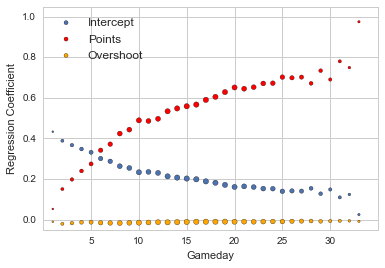

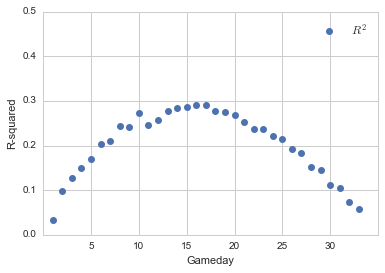

In [198]:
fig, ax = plt.subplots()
ax.set_xticks(range(5,35,5))
eval_parameters_curr_df.reset_index().loc[:, ["GD", "Intercept"]].plot(kind='scatter', x='GD', y='Intercept', label='Intercept',
                                                                       s=100*eval_parameters_curr_df.loc[:, "R^2"], 
                                                                       xlim=(0,35), ylim=(-0.05, 1.05), ax=ax)

eval_parameters_curr_df.reset_index().loc[:, ["GD", "Points"]].plot(kind='scatter', x='GD', y='Points', label='Points',
                                                                    s=100*eval_parameters_curr_df.loc[:, "R^2"], c='r',
                                                                    xlim=(0,35), ylim=(-0.05, 1.05), ax=ax)

eval_parameters_curr_df.reset_index().loc[:, ["GD", "Overshoot"]].plot(kind='scatter', x='GD', y='Overshoot', label='Overshoot',
                                                                       s=100*eval_parameters_curr_df.loc[:, "R^2"], c='orange',
                                                                       xlim=(0,35), ylim=(-0.05, 1.05), ax=ax)
ax.set_xlabel("Gameday")
ax.set_ylabel("Regression Coefficient")
plt.legend(loc=2, fontsize=12)



fig, ax = plt.subplots()
ax.set_xticks(range(5,35,5))

eval_parameters_curr_df.loc[:, "R^2"].plot(xlim=(0,35), ylim=(0, 0.5), ax=ax, style='o', label='$R^2$')
ax.set_xlabel("Gameday")
ax.set_ylabel("R-squared")
plt.legend(fontsize=12)